# Импорты

In [38]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import trapezoid
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.base import clone

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42

# Загрузка данных

In [2]:
try:
    df_train = pd.read_csv('train_c.csv')
    df_test = pd.read_csv('test_c.csv')
except FileNotFoundError:
    print('File not found')
    sys.exit()

print(f"Размер тренировочного датасета: {df_train.shape}")
print(f"Размер тестового датасета: {df_test.shape}")
df_train.head()

Размер тренировочного датасета: (11017, 35)
Размер тестового датасета: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


# EDA

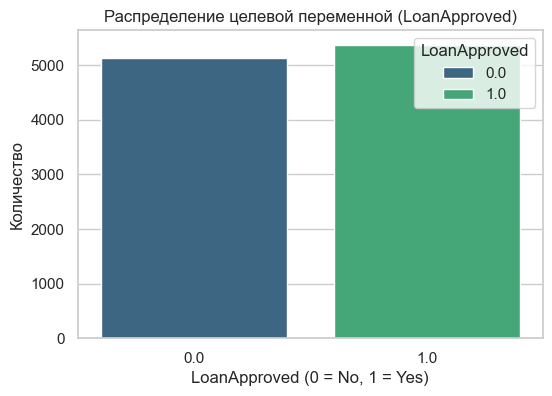

LoanApproved
1.0    0.511776
0.0    0.488224
Name: proportion, dtype: float64


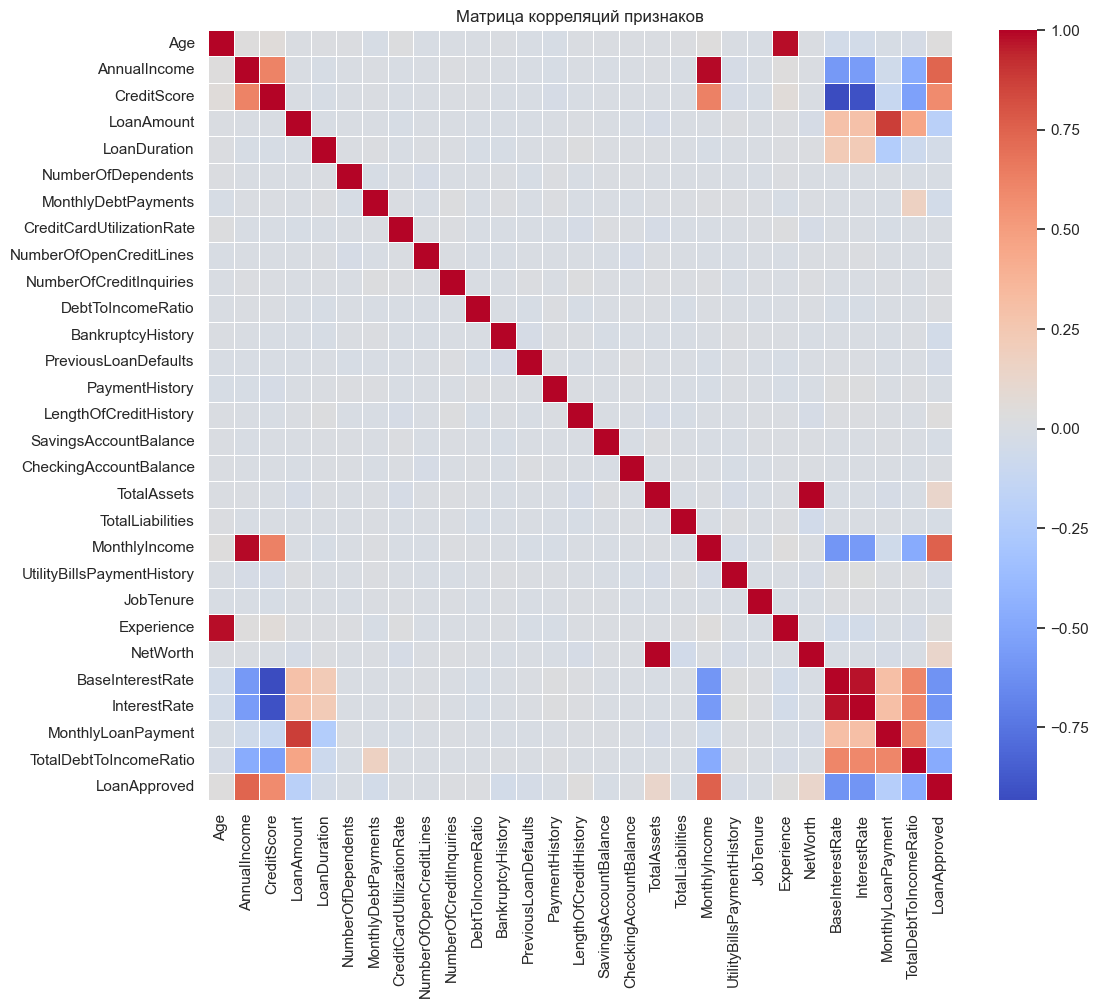

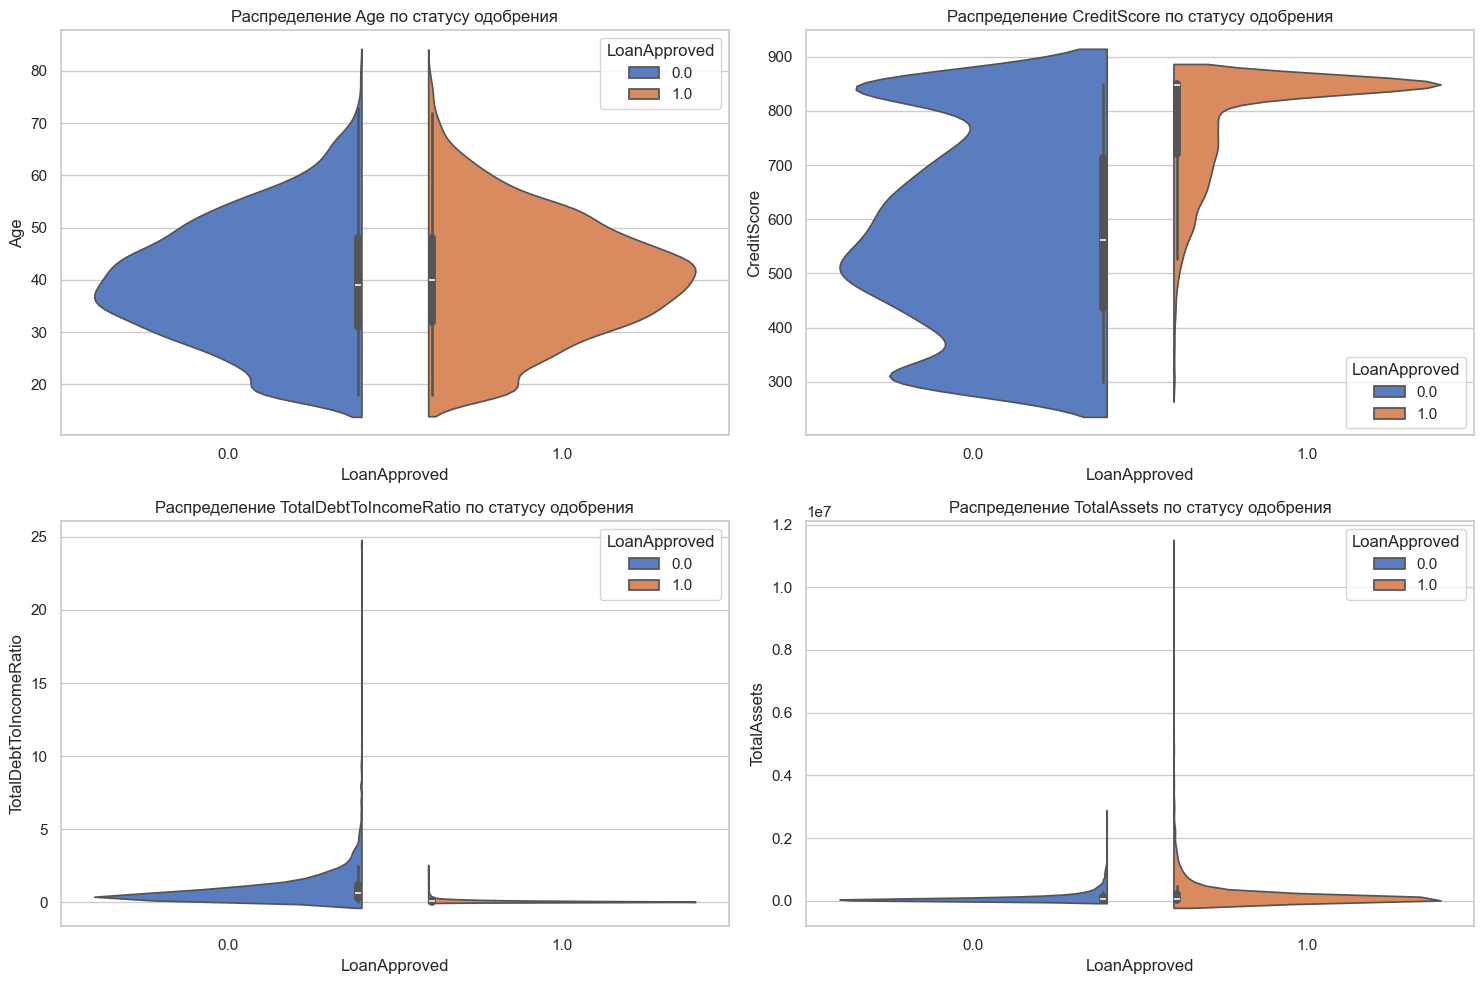

In [45]:
# 1. Распределение целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='LoanApproved', data=df_train, palette='viridis', hue='LoanApproved')
plt.title('Распределение целевой переменной (LoanApproved)')
plt.xlabel('LoanApproved (0 = No, 1 = Yes)')
plt.ylabel('Количество')
plt.show()

print(df_train['LoanApproved'].value_counts(normalize=True))

# 2. Матрица корреляций
plt.figure(figsize=(12, 10))
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
corr_matrix = df_train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций признаков')
plt.show()

# 3. Зависимости
features = ['Age', 'CreditScore', 'TotalDebtToIncomeRatio', 'TotalAssets']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=df_train, x='LoanApproved', y=feature, palette="muted", split=True, hue='LoanApproved')
    plt.title(f'Распределение {feature} по статусу одобрения')
    plt.tight_layout()

plt.show()

# Подготовка данных

In [33]:
target = 'LoanApproved'
X = df_train.drop(columns=[target])
y = df_train[target]

mask = y.notna()
X = X[mask]
y = y[mask]
print(f"Количество строк после удаления NaN в целевой переменной: {len(X)}")

X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded = X_encoded.fillna(X_encoded.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_test_encoded = pd.get_dummies(df_test, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.fillna(X_test_encoded.median())
X_test_scaled = scaler.transform(X_test_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

y_train = y_train.values
y_val = y_val.values

print("Данные подготовлены:")
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape:   {X_val.shape}, {y_val.shape}")

Количество строк после удаления NaN в целевой переменной: 10487
Данные подготовлены:
Train shape: (8389, 10043), (8389,)
Val shape:   (2098, 10043), (2098,)


# Метрики

In [34]:
class CustomMetrics:
    @staticmethod
    def accuracy(y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)

    @staticmethod
    def confusion_components(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp, tn, fp, fn

    @staticmethod
    def precision(y_true, y_pred):
        tp, _, fp, _ = CustomMetrics.confusion_components(y_true, y_pred)
        return tp / (tp + fp) if (tp + fp) > 0 else 0

    @staticmethod
    def recall(y_true, y_pred):
        tp, _, _, fn = CustomMetrics.confusion_components(y_true, y_pred)
        return tp / (tp + fn) if (tp + fn) > 0 else 0

    @staticmethod
    def f1_score(y_true, y_pred):
        p = CustomMetrics.precision(y_true, y_pred)
        r = CustomMetrics.recall(y_true, y_pred)
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

    @staticmethod
    def auc_roc(y_true, y_prob):
        desc_score_indices = np.argsort(y_prob)[::-1]
        y_true_sorted = np.array(y_true)[desc_score_indices]

        tps = np.cumsum(y_true_sorted)
        fps = np.cumsum(1 - y_true_sorted)

        tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
        fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps)

        return trapezoid(tpr, fpr)

    @staticmethod
    def auc_pr(y_true, y_prob):
        precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
        return average_precision_score(y_true, y_prob)

# Тестирование метрик
y_dummy_true = np.array([1, 0, 1, 1, 0, 1, 0, 0])
y_dummy_pred = np.array([1, 0, 1, 0, 0, 1, 1, 0])
y_dummy_prob = np.array([0.9, 0.1, 0.8, 0.4, 0.2, 0.7, 0.6, 0.3])

print("--- (Custom vs Sklearn) ---")
print(f"Accuracy:  {CustomMetrics.accuracy(y_dummy_true, y_dummy_pred):.4f} vs {accuracy_score(y_dummy_true, y_dummy_pred):.4f}")
print(f"Precision: {CustomMetrics.precision(y_dummy_true, y_dummy_pred):.4f} vs {precision_score(y_dummy_true, y_dummy_pred):.4f}")
print(f"Recall:    {CustomMetrics.recall(y_dummy_true, y_dummy_pred):.4f} vs {recall_score(y_dummy_true, y_dummy_pred):.4f}")
print(f"F1 Score:  {CustomMetrics.f1_score(y_dummy_true, y_dummy_pred):.4f} vs {f1_score(y_dummy_true, y_dummy_pred):.4f}")
print(f"AUC-ROC:   {CustomMetrics.auc_roc(y_dummy_true, y_dummy_prob):.4f} vs {roc_auc_score(y_dummy_true, y_dummy_prob):.4f}")
print(f"AUC-PR:    {CustomMetrics.auc_pr(y_dummy_true, y_dummy_prob):.4f} vs {average_precision_score(y_dummy_true, y_dummy_prob):.4f}")

--- (Custom vs Sklearn) ---
Accuracy:  0.7500 vs 0.7500
Precision: 0.7500 vs 0.7500
Recall:    0.7500 vs 0.7500
F1 Score:  0.7500 vs 0.7500
AUC-ROC:   0.9375 vs 0.9375
AUC-PR:    0.9500 vs 0.9500


# Beggin, beggin you
# Put your loving hand out baby
# Beggin, beggin you
# Put your loving hand out darling

Обучение Custom Bagging...
Обучение Sklearn RandomForest...

Результаты:
Custom Bagging ROC-AUC: 0.9760
Sklearn RF ROC-AUC:     0.9445


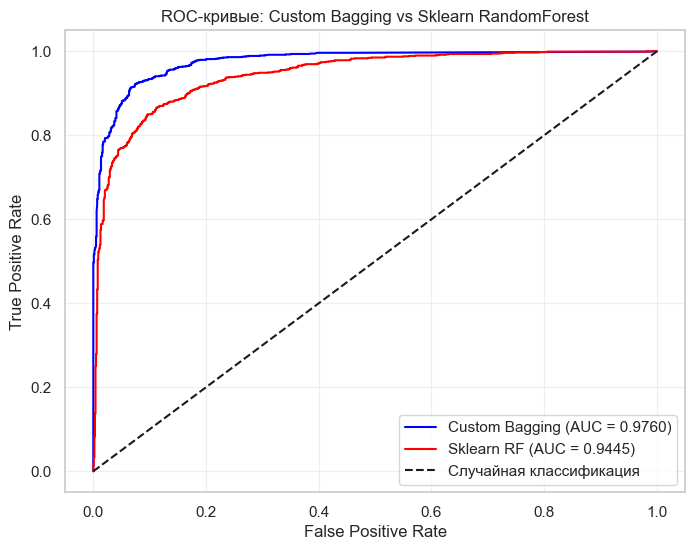

In [46]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.models = []
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            indices = rng.choice(n_samples, size=n_samples, replace=True)

            X_sample = X[indices]
            y_sample = y[indices]

            if self.base_estimator is None:
                model = DecisionTreeClassifier(max_depth=10, random_state=self.random_state + i)
            else:
                model = clone(self.base_estimator)

            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self

    def predict_proba(self, X):
        probas_list = np.array([model.predict_proba(X)[:, 1] for model in self.models])

        # Усредняем
        avg_proba = np.mean(probas_list, axis=0)

        return np.vstack([1 - avg_proba, avg_proba]).T

    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(int)


# Сравнение
print("Обучение Custom Bagging...")
bagging_custom = CustomBaggingClassifier(n_estimators=20, random_state=42)
bagging_custom.fit(X_train, y_train)
y_pred_bag = bagging_custom.predict_proba(X_val)[:, 1]

print("Обучение Sklearn RandomForest...")
rf_sklearn = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
rf_sklearn.fit(X_train, y_train)
y_pred_rf = rf_sklearn.predict_proba(X_val)[:, 1]

print(f"\nРезультаты:")
auc_bag = CustomMetrics.auc_roc(y_val, y_pred_bag)
auc_rf = CustomMetrics.auc_roc(y_val, y_pred_rf)
print(f"Custom Bagging ROC-AUC: {auc_bag:.4f}")
print(f"Sklearn RF ROC-AUC:     {auc_rf:.4f}")

fpr_bag, tpr_bag, _ = roc_curve(y_val, y_pred_bag)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, label=f'Custom Bagging (AUC = {auc_bag:.4f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Sklearn RF (AUC = {auc_rf:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная классификация')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые: Custom Bagging vs Sklearn RandomForest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Градиентный бустинг

In [49]:
class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        self.initial_prediction = 0.0

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.models = []

        pos_frac = np.mean(y)
        pos_frac = np.clip(pos_frac, 1e-10, 1-1e-10)
        self.initial_prediction = np.log(pos_frac / (1 - pos_frac))

        current_prediction = np.full(y.shape, self.initial_prediction)

        for i in range(self.n_estimators):
            p = self._sigmoid(current_prediction)
            residuals = y - p

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state + i)
            tree.fit(X, residuals)
            self.models.append(tree)

            update = tree.predict(X)
            current_prediction += self.learning_rate * update

        return self

    def predict_proba(self, X):
        current_prediction = np.full(X.shape[0], self.initial_prediction)
        for tree in self.models:
            current_prediction += self.learning_rate * tree.predict(X)

        probas = self._sigmoid(current_prediction)
        return np.vstack([1 - probas, probas]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)


# Сравнение
print("Обучение Custom Boosting...")
gb_custom = CustomGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
gb_custom.fit(X_train, y_train)
y_pred_gb_custom = gb_custom.predict_proba(X_val)[:, 1]

print("Обучение Sklearn GradientBoosting...")
gb_sklearn = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
gb_sklearn.fit(X_train, y_train)
y_pred_gb_sklearn = gb_sklearn.predict_proba(X_val)[:, 1]

print(f"\nCustom Boosting ROC-AUC: {CustomMetrics.auc_roc(y_val, y_pred_gb_custom):.4f}")
print(f"Sklearn Boosting ROC-AUC: {CustomMetrics.auc_roc(y_val, y_pred_gb_sklearn):.4f}")

Обучение Custom Boosting...
Обучение Sklearn GradientBoosting...

Custom Boosting ROC-AUC: 0.9730
Sklearn Boosting ROC-AUC: 0.9792


# Сравнение библиотек sklearn, LightGBM, XGBoost, CatBoost

CustomGradientBoostingClassifier ROC-AUC = 0.9730
Sklearn GB   ROC-AUC = 0.9803
XGBoost      ROC-AUC = 0.9822
LightGBM     ROC-AUC = 0.9812
CatBoost     ROC-AUC = 0.9812


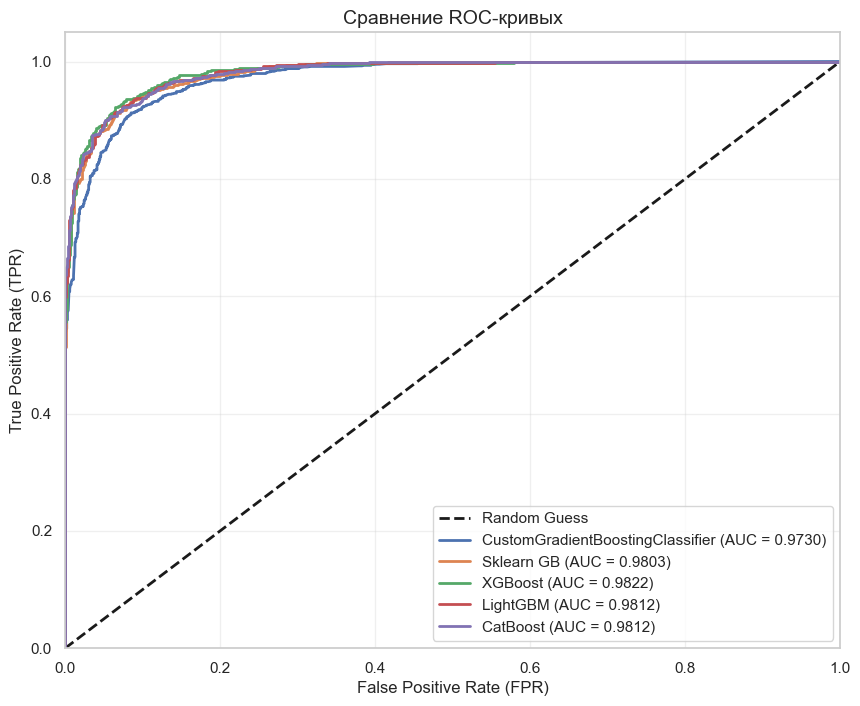


 Лучшая модель: XGBoost


In [51]:
models_zoo = {
    "CustomGradientBoostingClassifier": CustomGradientBoostingClassifier(random_state=42),
    "Sklearn GB": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
}

results = {}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

for name, model in models_zoo.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]

    score = CustomMetrics.auc_roc(y_val, y_prob)
    results[name] = score

    fpr, tpr, _ = roc_curve(y_val, y_prob)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {score:.4f})')
    print(f"{name:12} ROC-AUC = {score:.4f}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Сравнение ROC-кривых', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

best_model_name = max(results, key=results.get)
print(f"\n Лучшая модель: {best_model_name}")

# Оптимизация гиперпараметров с помощью Optuna

In [57]:
def objective(trial, model_name):
    if model_name == "CatBoost":
        params = {
            'iterations': trial.suggest_int('iterations', 100, 800),
            'depth': trial.suggest_int('depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'verbose': 0,
            'random_state': 42,
            'allow_writing_files': False
        }
        model = cb.CatBoostClassifier(**params)

    elif model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        model = xgb.XGBClassifier(**params)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150), # LGBM использует листья, а не глубину
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'verbose': -1,
            'random_state': 42
        }
        model = lgb.LGBMClassifier(**params)

    elif model_name == "Sklearn GB":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)

    elif model_name == "CustomGradientBoostingClassifier":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
            'random_state': 42
        }
        model = CustomGradientBoostingClassifier(**params)

    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]

    return CustomMetrics.auc_roc(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, best_model_name), n_trials=15)

print(f"\nЛучшие параметры для {best_model_name}: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value:.4f}")

[I 2025-12-08 13:28:18,433] A new study created in memory with name: no-name-2b8fcc4b-a50d-48d4-b56e-33fd636ed6bb
[I 2025-12-08 13:29:03,464] Trial 0 finished with value: 0.9819072247439478 and parameters: {'n_estimators': 711, 'max_depth': 3, 'learning_rate': 0.16746382796823334, 'subsample': 0.9462103095250283, 'colsample_bytree': 0.9653595326226578}. Best is trial 0 with value: 0.9819072247439478.
[I 2025-12-08 13:30:01,771] Trial 1 finished with value: 0.9830874650837989 and parameters: {'n_estimators': 637, 'max_depth': 7, 'learning_rate': 0.06742641180110204, 'subsample': 0.5024270713443257, 'colsample_bytree': 0.6909548952578825}. Best is trial 1 with value: 0.9830874650837989.
[I 2025-12-08 13:30:33,592] Trial 2 finished with value: 0.9815344215549348 and parameters: {'n_estimators': 378, 'max_depth': 6, 'learning_rate': 0.18556900905047496, 'subsample': 0.793096501954343, 'colsample_bytree': 0.9778166371314727}. Best is trial 1 with value: 0.9830874650837989.
[I 2025-12-08 13:


Лучшие параметры для XGBoost: {'n_estimators': 660, 'max_depth': 9, 'learning_rate': 0.0991004516963575, 'subsample': 0.5712924166319207, 'colsample_bytree': 0.7069894925057647}
Лучший ROC-AUC: 0.9833


# Создаём submission.csv

In [58]:
best_params = study.best_params

if best_model_name == "CatBoost":
    best_params['verbose'] = 0
    best_params['allow_writing_files'] = False
    best_params['random_state'] = 42
    final_model = cb.CatBoostClassifier(**best_params)

elif best_model_name == "XGBoost":
    best_params['use_label_encoder'] = False
    best_params['eval_metric'] = 'logloss'
    best_params['random_state'] = 42
    final_model = xgb.XGBClassifier(**best_params)

elif best_model_name == "LightGBM":
    best_params['verbose'] = -1
    best_params['random_state'] = 42
    final_model = lgb.LGBMClassifier(**best_params)

elif best_model_name == "Sklearn GB":
    best_params['random_state'] = 42
    final_model = GradientBoostingClassifier(**best_params)

elif best_model_name == "CustomGradientBoostingClassifier":
    best_params['random_state'] = 42
    final_model = CustomGradientBoostingClassifier(**best_params)

X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

final_model.fit(X_full, y_full)
test_probs = final_model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame()
submission['ID'] = df_test['ID']
submission['LoanApproved'] = test_probs

submission.to_csv('submission.csv', index=False)
print(f"Использованная модель: {best_model_name}")
print(submission.head())

Использованная модель: XGBoost
   ID  LoanApproved
0   0      0.999978
1   1      0.000099
2   2      0.999971
3   3      0.999926
4   4      0.999828


# С нашей моделью

In [59]:
def objective_custom(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'random_state': 42
    }

    model = CustomGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]

    return CustomMetrics.auc_roc(y_val, preds)


study_custom = optuna.create_study(direction='maximize')
study_custom.optimize(objective_custom, n_trials=15)

print(f"\nЛучшие параметры для CustomBoosting: {study_custom.best_params}")
print(f"Лучший ROC-AUC на валидации: {study_custom.best_value:.4f}")

best_custom_params = study_custom.best_params
best_custom_params['random_state'] = 42
final_custom_model = CustomGradientBoostingClassifier(**best_custom_params)

X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

final_custom_model.fit(X_full, y_full)


custom_test_probs = final_custom_model.predict_proba(X_test_scaled)[:, 1]
submission_custom = pd.DataFrame()
submission_custom['ID'] = df_test['ID']
submission_custom['LoanApproved'] = custom_test_probs

submission_custom.to_csv('submission1.csv', index=False)
print(submission_custom.head())

[I 2025-12-08 13:44:56,044] A new study created in memory with name: no-name-76932d6b-f0c6-42cc-a1e1-164d03c79d4a
[I 2025-12-08 13:46:00,558] Trial 0 finished with value: 0.9742056564245809 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.14541110172779637}. Best is trial 0 with value: 0.9742056564245809.
[I 2025-12-08 13:47:44,059] Trial 1 finished with value: 0.9718133510824021 and parameters: {'n_estimators': 52, 'max_depth': 2, 'learning_rate': 0.2584790615075173}. Best is trial 0 with value: 0.9742056564245809.
[I 2025-12-08 13:48:56,191] Trial 2 finished with value: 0.9772844652001863 and parameters: {'n_estimators': 29, 'max_depth': 6, 'learning_rate': 0.2767731753150767}. Best is trial 2 with value: 0.9772844652001863.
[I 2025-12-08 13:50:12,728] Trial 3 finished with value: 0.9766070545274673 and parameters: {'n_estimators': 31, 'max_depth': 6, 'learning_rate': 0.2370399307270627}. Best is trial 2 with value: 0.9772844652001863.
[I 2025-12-08 13:52:14,98


Лучшие параметры для CustomBoosting: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.29762358924675486}
Лучший ROC-AUC на валидации: 0.9794
   ID  LoanApproved
0   0      0.956933
1   1      0.051380
2   2      0.956952
3   3      0.956948
4   4      0.953053
